<div> 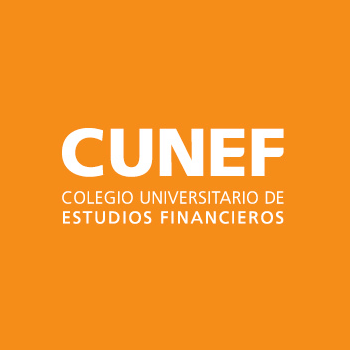
</div>


# **Petróleo (WTI)**
En este notebook se mostrará la serie temporal del **precio histórico del crudo (WTI)** y observaremos cómo afectó ésta frente al COVID-19. 



Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura y preprocesado de los datos
    3) EDA (Análisis Exploratorio de Datos)
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
    5) Predicción hasta finales de año 

## *1) Librerías*

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *2) Lectura del CSV y preparación de los datos*
Se procede a leer el archivo CSV de los datos históricos del petróleo crudo (WTI)

- Fuente: https://es.finance.yahoo.com/quote/WTI/history?period1=1106870400&period2=1651968000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [59]:
df_wti = pd.read_csv("wti.csv")
df_wti['Date'] = pd.to_datetime(df_wti['Date'])
df_wti = df_wti.set_index("Date")
df_wti

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2022-08-01,89.02,97.95,98.42,85.73,386.27K,-9.73%
2022-07-01,98.62,106.30,111.44,90.58,349.37K,-7.15%
2022-06-01,106.22,115.10,123.66,101.58,5.15M,-7.37%
2022-05-01,114.67,104.00,119.98,98.20,5.32M,9.53%
2022-04-01,104.69,101.23,109.81,92.93,5.39M,4.40%
...,...,...,...,...,...,...
2005-05-01,51.97,49.28,53.10,46.20,2.06M,4.53%
2005-04-01,49.72,55.25,58.28,49.50,2.10M,-10.25%
2005-03-01,55.40,51.77,57.60,50.65,2.12M,7.05%


Nos vamos a quedar con los valores de **"Price"** ya que es el precio de cierre del crudo y es lo que nos interesa estudiar para ver su evolución en el tiempo, y además voltearemos los datos para que salgan los últimos datos los más recientes y no al revés:

In [60]:
df_wti=df_wti.drop(columns=['Open','High','Low','Vol.','Change %'])
df_wti=df_wti.iloc[::-1]
df_wti

,Price
Date,
2005-01-01,48.20
2005-02-01,51.75
2005-03-01,55.40
2005-04-01,49.72
2005-05-01,51.97
...,...
2022-04-01,104.69
2022-05-01,114.67
2022-06-01,106.22


## *3) EDA*

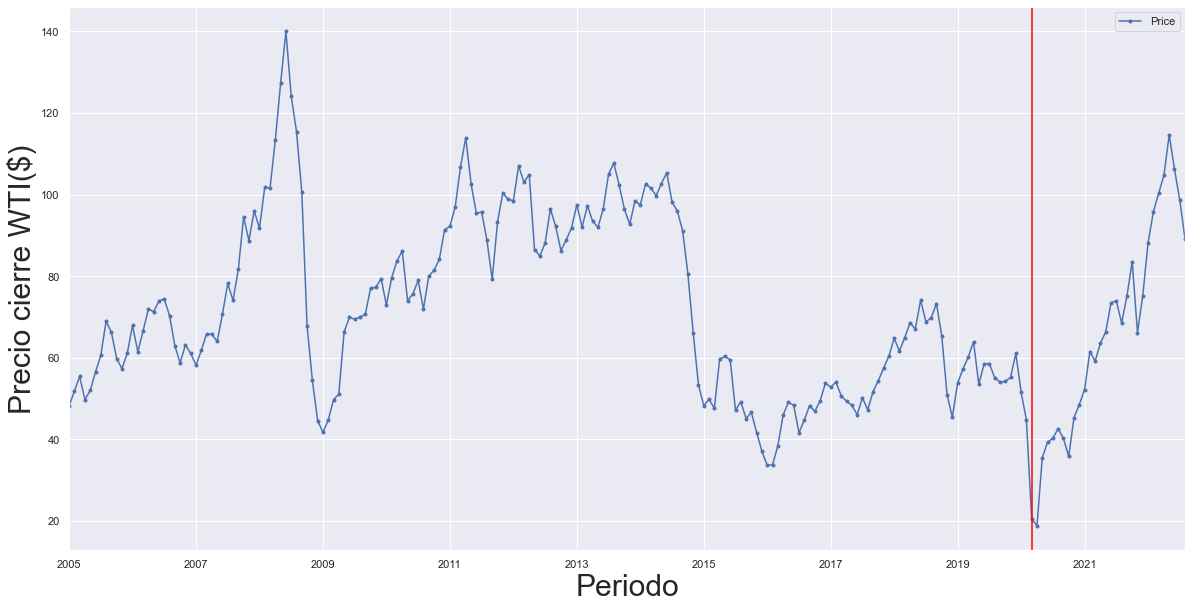

In [61]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_wti.plot(marker='.') 
fig.set_ylabel('Precio cierre WTI($)', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30);

Con el fin de ver mejor la gráfica de la serie temporal en un periodo más reciente, recortamos a partir de enero del 2014 en adelante:

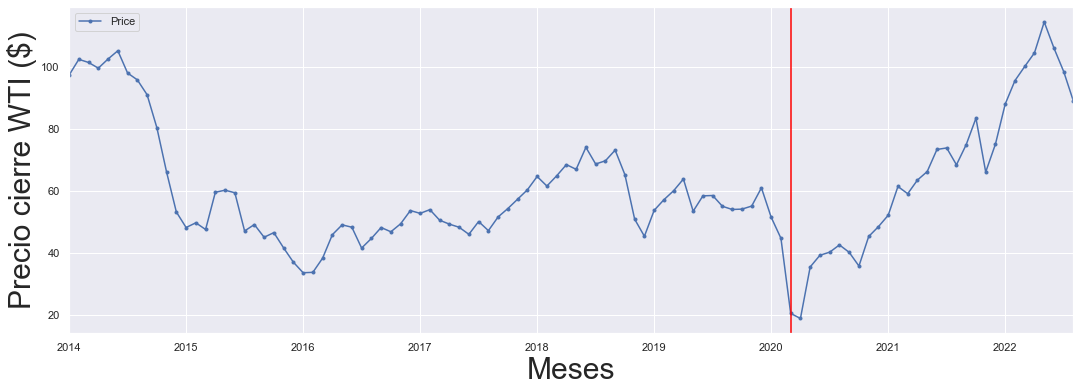

In [62]:
df_wti = df_wti.iloc[108:]

sns.set(rc={'figure.figsize':(18, 6)})
fig = df_wti.plot(marker='.') 
fig.set_ylabel('Precio cierre WTI ($)', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Meses', fontsize = 30);

En la gráfica podemos apreciar una tendencia decreciente desde el principio hasta mediados del 2017, luego sube hasta finales del 2019, donde vuelve a bajar y se acentúa con el periodo COVID-19.


A continuación, analizaremos la estacionalidad y comprobaremos si la serie temporal es estacionaria mediante:
- Cálculo de la media y de la varianza
- Test de Dickey-Fuller aumentada
- Gráficas de comportamiento mensual
- Descomposición

Para que no nos afecte al análisis la situación anómala provocada por COVID-19, **analizaremos sólamente hasta el último mes antes del inicio de la pandemia**, esto es, **el mes de febrero del 2020**.

In [68]:
df_wti_eda=df_wti.iloc[:74,:]
df_wti_eda

,Price
Date,
2014-01-01,97.49
2014-02-01,102.59
2014-03-01,101.58
2014-04-01,99.74
2014-05-01,102.71
...,...
2019-10-01,54.18
2019-11-01,55.17
2019-12-01,61.06


### 3.1) Cálculo de la media y de la varianza

In [71]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

media=split_and_summarize(df_wti_eda, 'Price', 4, np.mean)
varianza=split_and_summarize(df_wti_eda, 'Price', 4, np.var)

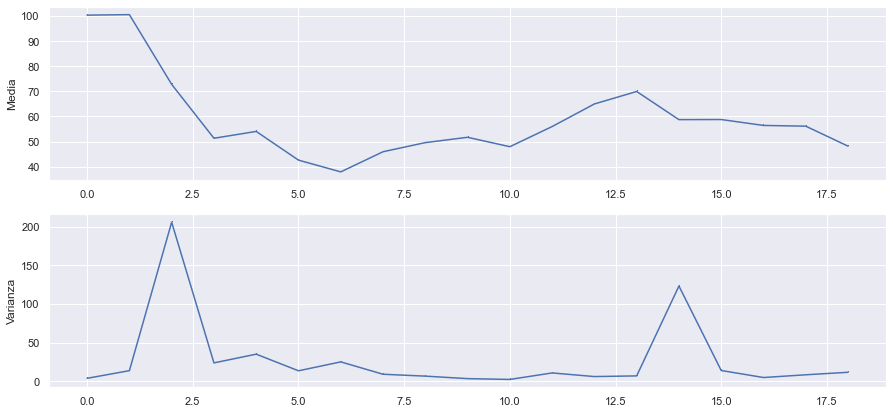

In [72]:
cols = ['media', 'varianza']
df = pd.DataFrame([media, varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()
# fig.figure.savefig('../pics/df_hipotecas/meanvariance.png')

A simple vista la media y la varianza no son constantes a lo largo del tiempo. Vamos a observarlo con el Test de Dickey-Fuller aumentado.

### 3.2. Test de Dickey-Fuller aumentada

Esta prueba nos proporciona una verificación rápida y evidente de si la serie es estacionaria o no.

**La hipótesis nula (H0)** de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria, es decir, que tiene alguna estructura dependiente del tiempo. 

**La hipótesis alternativa (H1)**, que rechaza la hipótesis nula, indica que la serie temporal es estacionaria.

Interpretamos este resultado utilizando el p-value. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza.

In [73]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_wti_eda)

Results of Dickey-Fuller Test:
Test Statistic                 -2.133933
p-value                         0.231091
#Lags Used                      0.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
dtype: float64


**La serie temporal NO es estacionaria**, debido a que el p-value del test Dickey-Fuller (0.23) es mayor que 0.05, y eso indica que se acepta la hipótesis nula (H0).

Además, vemos que nuestro test estadístico (-2.13) es mayor que los umbrales de significancia del 1%, 5% y 10%, lo que nos da más indicios de que es una serie que posee alguna estructura dependiente del tiempo.

### 3.3) Gráficas de comportamiento mensual

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

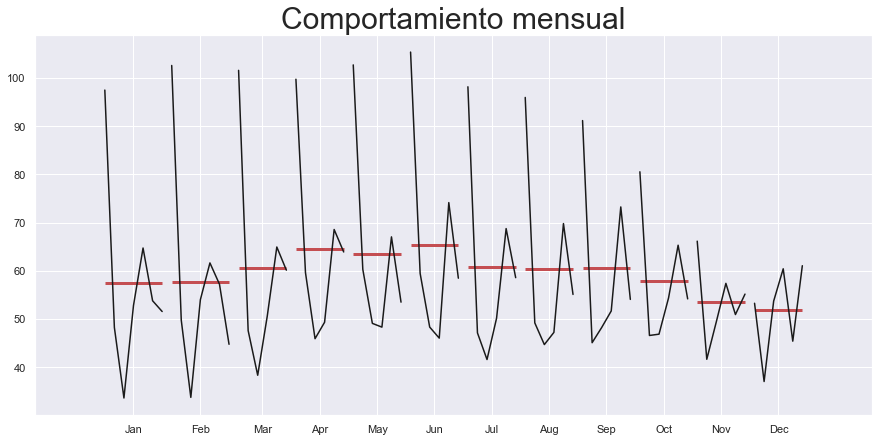

In [74]:
# Componente estacional mensual:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_wti_eda['Price'], ax = ax)
ax.set_title('Comportamiento mensual', fontsize = 30);
# ax.figure.savefig('../pics/df_hipotecas/monthbehavior.png')

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

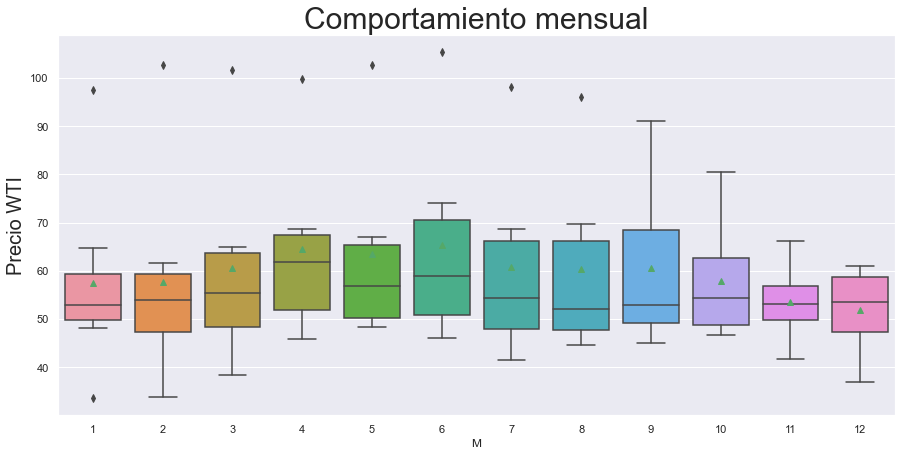

In [77]:
df_wti_eda['M'] = df_wti_eda.index.month
sns.boxplot(data = df_wti_eda, x = 'M', y='Price', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Precio WTI', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);
# ax.figure.savefig('../pics/df_hipotecas/boxplotmonth.png')

**No se aprecia una estacionalidad marcada** y aparte hay valores atípicos los 8 primeros meses.

### 3.4.) Descomposición

Y, por último, vamos a realizar la descomposición de la serie temporal de las hipotecas, que nos indica de un solo vistazo la estacionalidad, la tendencia y los residuos:

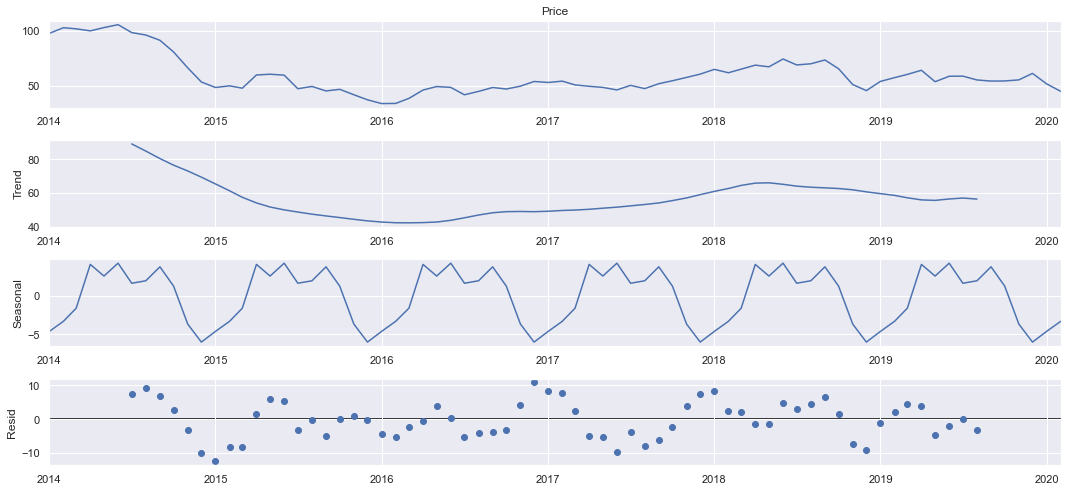

In [78]:
desglose = seasonal_decompose(df_wti_eda['Price'], 
                                   model='additive', 
                                   period=12);
desglose.plot();
# plt.savefig('../pics/df_hipotecas/decompose.png')

Analizando las gráficas, observamos:
- **La tendencia es decreciente al principio, luego sube y luego se mantiene**.
- **No se aprecia estacionalidad**.
- **No se trata de una serie estacionaria** debido a la irregularidad que hay en la media y en la varianza.

## *4) Estimación mediante modelos*

### 4.1) Modelo de Suavizado Exponencial (ETS)

A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en el tiempo que ha habido desde el inicio de la pandemia, es decir, desde marzo del 2020. Como el dataset tiene datos hasta mayo del 2022, hay 27 meses para el test_size.



Cantidad de períodos en Train: 74
Cantidad de períodos en Test: 30


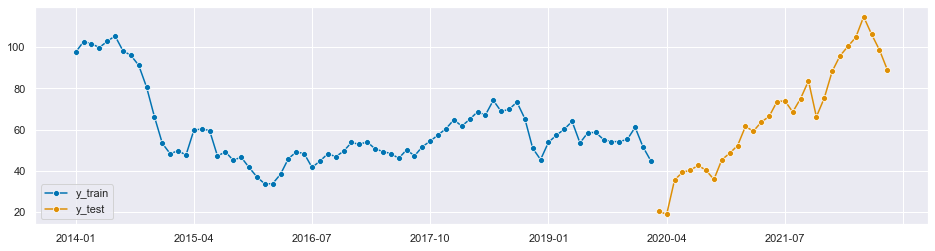

In [124]:
#Train-test
y_train, y_test = temporal_train_test_split(
    y = df_wti.astype('float64').to_period('M').sort_index(),test_size=30)
#Grafico para representar la separación de los datos
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0])
plt.show()

In [125]:
y_test #observamos los 30 meses testeados

,Price
2020-03,20.48
2020-04,18.84
2020-05,35.49
2020-06,39.27
2020-07,40.27
2020-08,42.61
2020-09,40.22
2020-10,35.79
2020-11,45.34
2020-12,48.52


Se realiza el pronóstico (forecasting) del horizonte temporal de 2 años. En sp, que es el número de periodos en un ciclo estacional completo, pondremos 12 para datos mensuales con ciclo anual:

In [126]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
wti_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)

In [127]:
wti_auto_ets.fit(y_train)
wti_auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   74
Model:                       ETS(MNN)   Log Likelihood                -229.612
Date:                Wed, 31 Aug 2022   AIC                            465.225
Time:                        22:44:12   BIC                            472.137
Sample:                    01-31-2014   HQIC                           467.982
                         - 02-29-2020   Scale                            0.009
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.117      8.577      0.000       0.771       1.228
initial_level      96.6717      8.901     10.861      0.000      79.226     114.117
===================================================================================
Ljung-Box (Q):                        2.67   Jarque-Bera (JB):                 0.11
Prob(Q):                              0.26   Prob(JB):                         0.95
Heteroskedasticity (H):               0.95   Skew:                            -0.06
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [128]:
#step 5: querying predictions
wti_pred = wti_auto_ets.predict(fh=list(fh))
wti_pred.round()

,Price
2020-03,45.0
2020-04,45.0
2020-05,45.0
2020-06,45.0
2020-07,45.0
2020-08,45.0
2020-09,45.0
2020-10,45.0
2020-11,45.0
2020-12,45.0


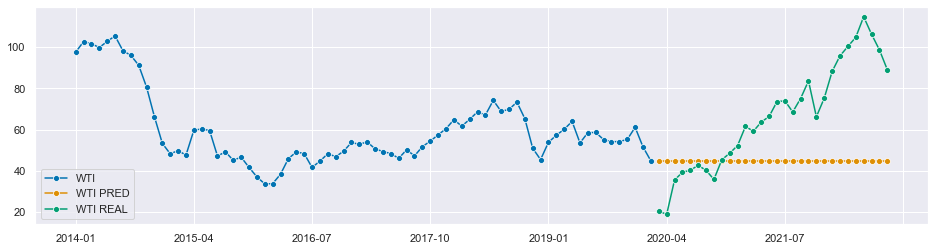

In [129]:
# optional: plotting predictions and past data
plot_series(y_train, wti_pred, y_test,
            labels=["WTI", "WTI PRED", "WTI REAL"])
plt.show()

Se hace un zoom al gráfico:

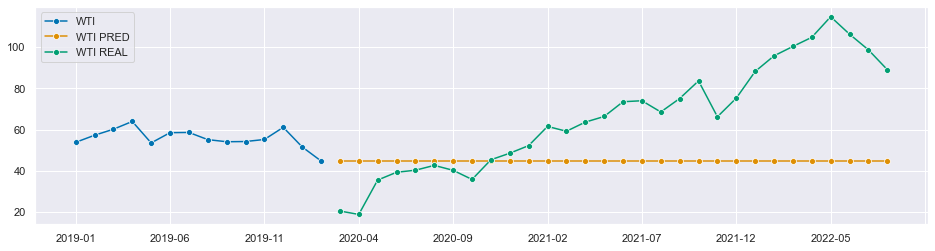

In [130]:
plot_series(y_train["2019":], wti_pred,y_test,
            labels=["WTI", "WTI PRED", "WTI REAL"]);

La predicción por ETS, a simple vista, no predice con mucha certeza el momento del inicio de la pandemia, pero a partir de marzo del 2021 sí que afina más su precisión. Vamos a calcular el error de las predicciones mediante el RMSE y MAPE. 

In [131]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test, wti_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

El modelo ETS genera un RMSE de: 33.47


In [132]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test, wti_pred)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un MAPE de: 39.89%


### 4.2) Modelo ARIMA

Al tratarse de una serie no estacionaria en media ni en varianza, debemos transformar a la serie para tener un correcto tratamiento de la misma y de esta manera, obtener las mejores predicciones posibles con el método de estimacion ARIMA.

Es necesario lograr que la serie sea estacionaria en varianza, luego el algoritmo es capaz de interpretar datos no estacionarios en media. Para ello, aplicaremos logaritmo y luego lo ploteamos para evidenciar si se ha logrado el objetivo.

In [133]:
transformer = LogTransformer()
log_df_wti= transformer.fit_transform(df_wti)
log_df_wti.tail()

,Price
Date,
2022-04-01,4.651004
2022-05-01,4.742058
2022-06-01,4.665512
2022-07-01,4.591274
2022-08-01,4.488861


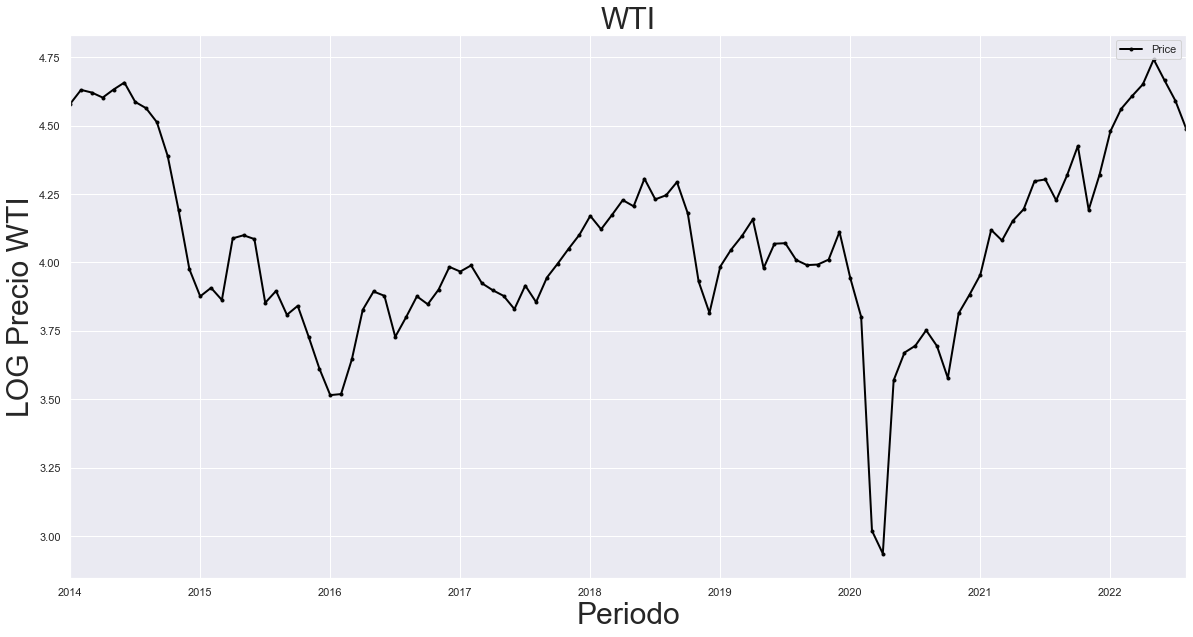

In [134]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = log_df_wti.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('WTI', fontsize = 30) 
fig.set_ylabel('LOG Precio WTI', fontsize = 30)
fig.set_xlabel('Periodo', fontsize = 30);

Separamos el train y test a la serie transformada en logs:

74 30


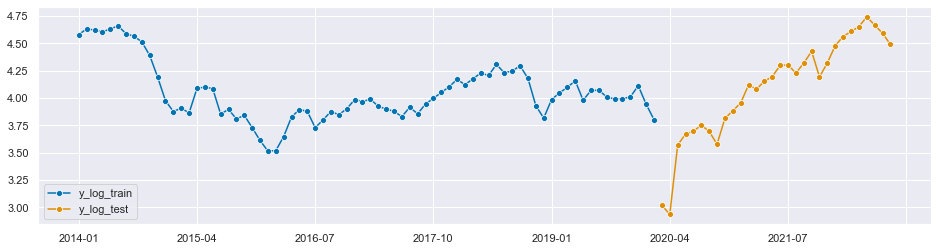

In [135]:
y_log_train,y_log_test=temporal_train_test_split(
    y=log_df_wti.astype('float64').to_period('M').sort_index(),test_size=30)
plot_series(y_log_train, y_log_test, labels=["y_log_train", "y_log_test"])
print(y_log_train.shape[0], y_log_test.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [151]:
fh = np.arange(1,y_log_test.shape[0]+1)
wti_auto_arima=AutoARIMA(d=1,D=1,sp=12,suppress_warnings=True)

In [152]:
wti_auto_arima.fit(y_log_train)
wti_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   74
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                  48.279
Date:                            Wed, 31 Aug 2022   AIC                            -86.559
Time:                                    22:47:37   BIC                            -76.004
Sample:                                         0   HQIC                           -82.422
                                             - 74                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2268      0.134      1.697      0.090      -0.035       0.489
ar.S.L12      -0.1411      0.448     -0.315      0.753      -1.019       0.737
ar.S.L24      -0.2209      0.329     -0.671      0.502      -0.866       0.424
ma.S.L12      -0.6220      0.605     -1.029      0.304      -1.807       0.563
sigma2         0.0100      0.003      3.447      0.001       0.004       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.78
Prob(Q):                              0.80   Prob(JB):                         0.68
Heteroskedasticity (H):               1.85   Skew:                            -0.06
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [153]:
wti_log_pred = wti_auto_arima.predict(fh)
np.exp(wti_log_pred)

,Price
2020-03,44.248719
2020-04,47.534474
2020-05,45.921755
2020-06,46.556159
2020-07,44.550229
2020-08,43.933113
2020-09,44.980857
2020-10,44.683890
2020-11,43.767001
2020-12,44.319693


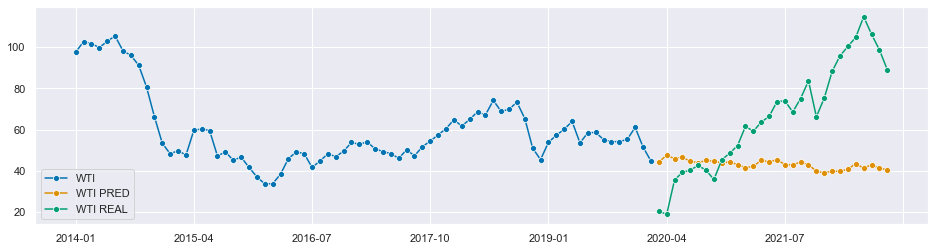

In [154]:
# representamos la serie predictiva
plot_series(np.exp(y_log_train), np.exp(wti_log_pred), np.exp(y_log_test), 
            labels=["WTI", "WTI PRED", "WTI REAL"])
plt.show()

In [155]:
mse = MeanSquaredError(square_root=True)
mse_log = mse(np.exp(y_log_test), np.exp(wti_log_pred))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ARIMA genera un RMSE de: 35.65


In [156]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_log = mape(np.exp(y_log_test), np.exp(wti_log_pred))
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_log*100,2)))

El modelo ARIMA genera un MAPE de: 42.76%


#### Una comparativa entre ETS y ARIMA

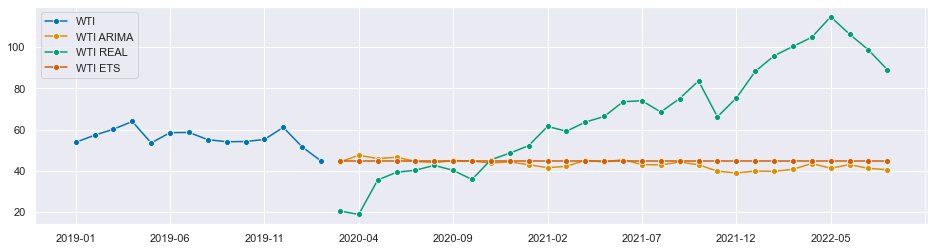

In [157]:
plot_series(np.exp(y_log_train["2019":]), np.exp(wti_log_pred), np.exp(y_log_test), wti_pred, 
            labels=["WTI", "WTI ARIMA", "WTI REAL", 'WTI ETS'])
plt.show()
# plt.savefig('../pics/df_hipotecas/etsarima.png')

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [158]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ETS genera un RMSE de: 33.47
El modelo ARIMA genera un RMSE de: 35.65


In [159]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))

El modelo ETS genera un MAPE de: 39.89%
El modelo ARIMA genera un MAPE de 42.76%


### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 

Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [160]:
prophet_train = df_wti.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [161]:
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

74

In [162]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

30

In [163]:
prophet_y_train.tail()

,ds,y
69,2019-10-31,54.18
70,2019-11-30,55.17
71,2019-12-31,61.06
72,2020-01-31,51.56
73,2020-02-29,44.76


In [164]:
prophet_y_test.head()

,ds,y
0,2020-03-31,20.48
1,2020-04-30,18.84
2,2020-05-31,35.49
3,2020-06-30,39.27
4,2020-07-31,40.27


In [165]:
m = Prophet()
m.fit(prophet_y_train)

22:48:05 - cmdstanpy - INFO - Chain [1] start processing
22:48:05 - cmdstanpy - INFO - Chain [1] done processing


In [166]:
m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

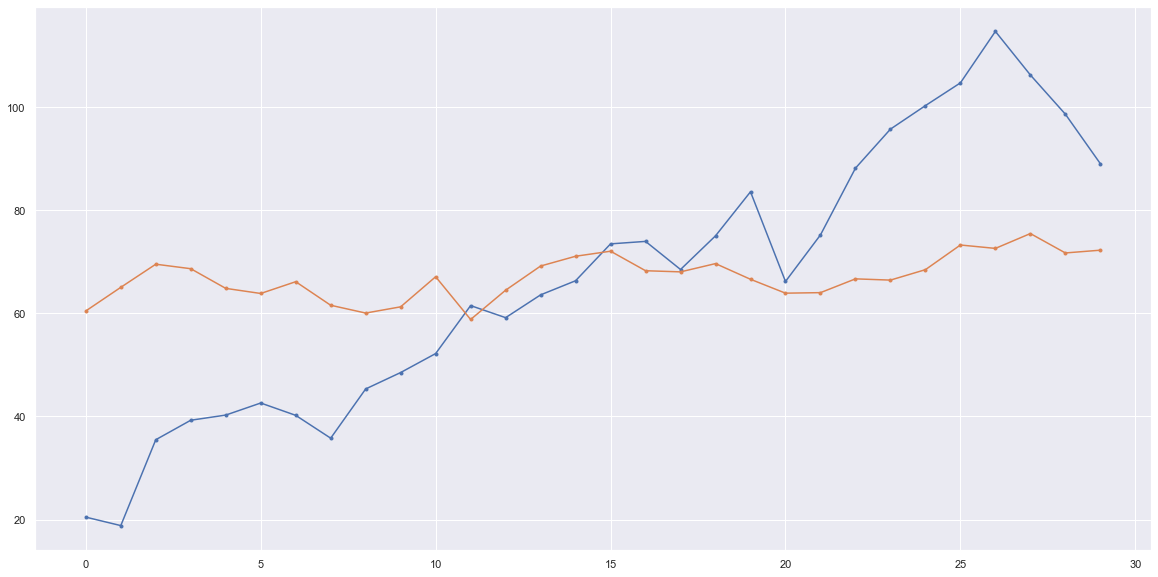

In [167]:
plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[74:, 'yhat']), '.-', label='Predicition')
plt.show()
# plt.savefig('../pics/df_hipotecas/prophet.png')

In [168]:
# Forecast Accuracy
# MAPE
# mape_prophet = mean_absolute_percentage_error(prophet_y_test['y'], prophet_forecast.loc[47:, 'yhat'])
# mape_prophet

mape = MeanAbsolutePercentageError(symmetric=False)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[74:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

El modelo Prophet genera un MAPE de: 41.99%


In [169]:
# Forecast Accuracy
#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[74:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un RMSE de: 23.35


In [170]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
99,2022-04-30,73.0,60.0,86.0
100,2022-05-31,73.0,58.0,87.0
101,2022-06-30,75.0,61.0,90.0
102,2022-07-31,72.0,57.0,87.0
103,2022-08-31,72.0,58.0,86.0


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [171]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 33.47
El modelo ARIMA genera un RMSE de: 35.65
El modelo Prophet genera un RMSE de: 23.35


2) MAPE (Error porcentual)

In [172]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 39.89%
El modelo ARIMA genera un MAPE de 42.76%
El modelo Prophet genera un MAPE de 41.99%


Confirmamos que **el mejor modelo para la predicción de esta serie temporal es el ETS**, ya que es el que mejor se ajusta a los datos reales y es el que menor error da.

## *5) Predicción hasta finales de año*

A continuación realizamos la predicción de la serie temporal del precio histórico del crudo hasta finales del 2022. 

In [176]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, 5)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
autoets_predict = AutoETS(auto=True, sp=12, n_jobs=-1)
y = df_wti.astype('float64').to_period('M')
autoets_predict.fit(y)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [177]:
print(autoets_predict.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  104
Model:                       ETS(ANN)   Log Likelihood                -343.317
Date:                Wed, 31 Aug 2022   AIC                            692.635
Time:                        22:52:30   BIC                            700.568
Sample:                    01-31-2014   HQIC                           695.849
                         - 08-31-2022   Scale                           43.137
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.105      9.511      0.000       0.794       1.206
initial_level      97.4924      6.590     14.795      0.000      84.577     110.408
Ljung-Box (Q):                  

In [178]:
# Predicción del desempleo para los próximos 6 meses:
wtinew_pred = autoets_predict.predict(fh=list(fh))
wtinew_pred.round()

,Price
2022-09,89.0
2022-10,89.0
2022-11,89.0
2022-12,89.0


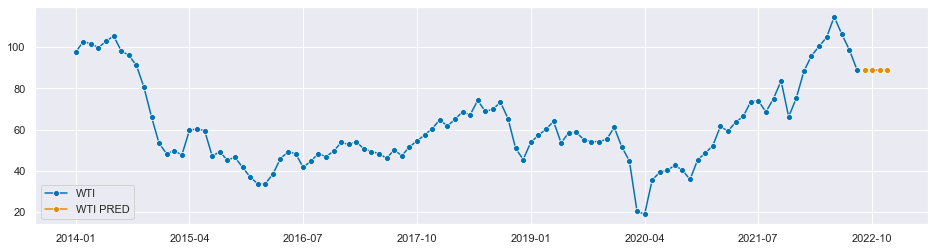

In [179]:
# Representamos gráficamente:
plot_series(y, wtinew_pred, labels=["WTI", "WTI PRED"])
plt.show()
# plt.savefig('../pics/df_paro/predict2022.png')

A continuación, en el Notebook "df_wti_new" realizaremos una intervención quitando el momento COVID-19 para comprobar cuánta de diferencia hay en la precisión de la predicción cuando no hay un momento atípico.